In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
path_files ='/content/drive/MyDrive/Colab Notebooks/Files'

In [ ]:
from os.path import join
import pandas as pd

# Recolección de Datos



In [ ]:
df=pd.read_csv(join(path_files,'ISR1000_sintetico.csv'),index_col=0)

In [ ]:
df

,Operating_Temperature_Nominal,Operating_Humidity_Nominal,Fan_Speed,Version,CPU,Memory,Failure_Last6Months
Device_ID,,,,,,,
ISR1000-0000,38.745401,57.848405,7429.811878,17.12,48.202212,93.967654,1
ISR1000-0001,44.507143,55.368869,7886.249891,17.12,41.691265,85.802337,1
ISR1000-0002,42.319939,61.095643,7045.750375,17.15,65.941671,90.245114,1
ISR1000-0003,40.986585,60.026790,7056.022283,17.90,64.387030,89.103968,0
ISR1000-0004,36.560186,55.514788,8233.900841,17.15,69.991530,94.823786,1
...,...,...,...,...,...,...,...
ISR1000-1795,38.689136,59.303059,7692.336212,17.12,61.254691,55.682804,0
ISR1000-1796,39.625347,57.005247,7013.997430,17.12,45.162677,54.126021,0
ISR1000-1797,42.474709,59.915945,7370.018297,17.90,69.172600,59.681651,0


# **Normalización de Datos**

In [ ]:
from sklearn.preprocessing import StandardScaler
# Features a usar para clustering
features = ["Operating_Temperature_Nominal",
            "Operating_Humidity_Nominal",
            "Fan_Speed",
            "CPU",
            "Memory"]

X = df[features].values

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **1 - PCA**

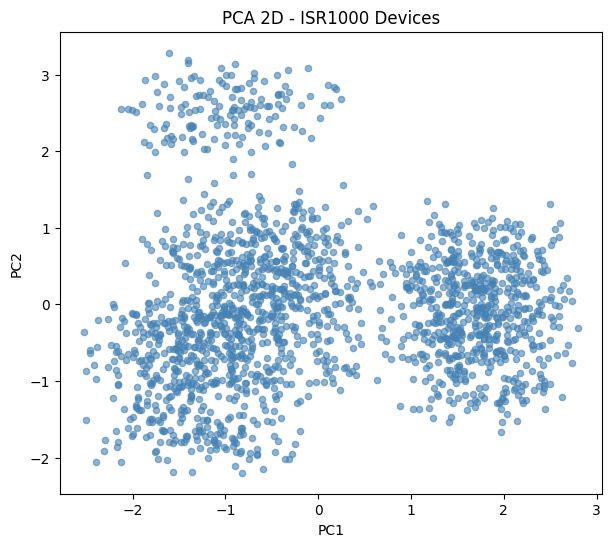

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2D con PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Graficar todos los puntos juntos
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], color="steelblue", alpha=0.6, s=20)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D - ISR1000 Devices")
plt.show()

# **2 - Clustering**

> Finding the optimal number of clusters K



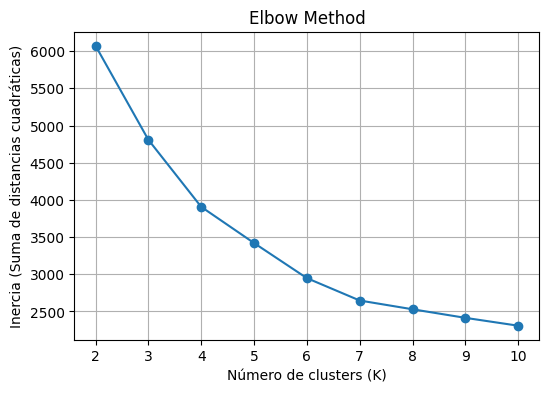

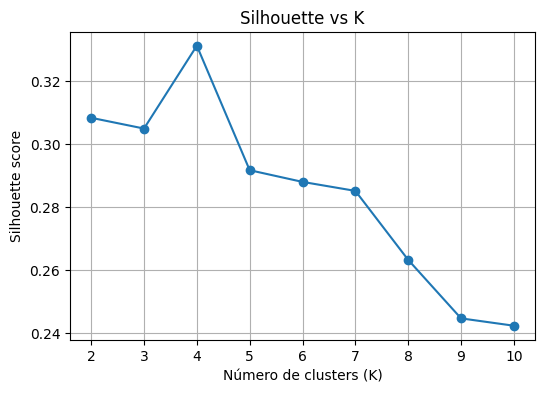

Mejor K por silhouette ≈ 4 (score=0.331)


In [ ]:
# --- Elbow + Silhouette para elegir K ---
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Usa tu matriz estandarizada:
# X_scaled = scaler.fit_transform(X)

Ks = range(2, 11)  # prueba K=2..10
inertias = []
silhouettes = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouettes.append(sil_score)

# Plot Elbow (Inertia)
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia (Suma de distancias cuadráticas)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(Ks, silhouettes, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette score')
plt.title('Silhouette vs K')
plt.grid(True)
plt.show()

# Resultado rápido
best_k_sil = Ks[int(np.argmax(silhouettes))]
print(f"Mejor K por silhouette ≈ {best_k_sil} (score={max(silhouettes):.3f})")


***Apply KMeans with 4 clusters***





📊 Porcentaje de fallos por cluster:
Cluster
0     9.047619
1    28.030303
2    75.000000
3     1.111111
Name: Failure_Last6Months, dtype: float64


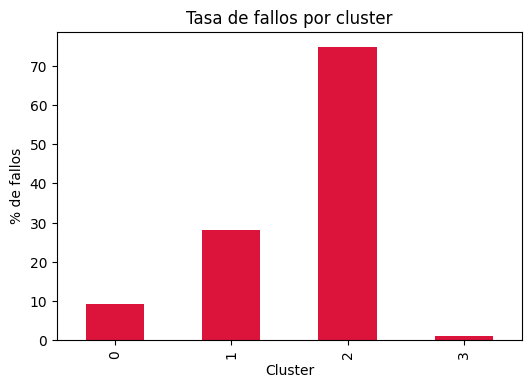

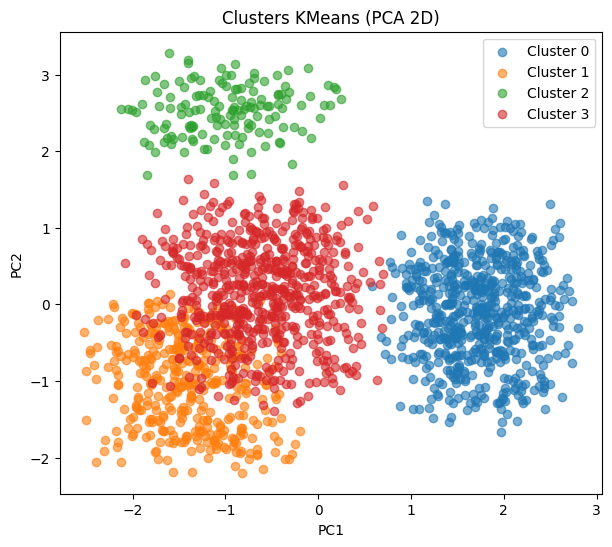

In [ ]:
# 5) KMeans con 4 clusters (hipótesis original)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# 6) Calcular % de fallos en cada cluster
failure_rates = df.groupby("Cluster")["Failure_Last6Months"].mean() * 100

print("📊 Porcentaje de fallos por cluster:")
print(failure_rates)

# 7) Gráfico: distribución de fallos por cluster
failure_rates.plot(kind="bar", color="crimson", figsize=(6,4))
plt.ylabel("% de fallos")
plt.title("Tasa de fallos por cluster")
plt.show()

# 8) Gráfico PCA 2D coloreado por cluster

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
for k in range(4):
    cluster_points = X_pca[df["Cluster"]==k]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f"Cluster {k}", alpha=0.6)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters KMeans (PCA 2D)")
plt.legend()
plt.show()


# **3 - Post Clustering Analysis**

In [ ]:
# Calcular medias de todos los features por cluster
cluster_means = (
    df.groupby("Cluster")[[
        "Operating_Temperature_Nominal",
        "Operating_Humidity_Nominal",
        "Fan_Speed",
        "CPU",
        "Memory",
        "Failure_Last6Months"
    ]]
    .mean()
    .round(2)
    .rename(columns={
        "Operating_Temperature_Nominal": "Temp(°C)",
        "Operating_Humidity_Nominal": "Hum(%)",
        "Fan_Speed": "Fan(RPM)",
        "CPU": "CPU(%)",
        "Memory": "Mem(%)",
        "Failure_Last6Months": "Fail_rate"
    })
)

# Convertir tasa de fallos a porcentaje
cluster_means["Fail_rate"] = (cluster_means["Fail_rate"] * 100).round(2)

cluster_means


,Temp(°C),Hum(%),Fan(RPM),CPU(%),Mem(%),Fail_rate
Cluster,,,,,,
0,49.98,60.00,9149.92,55.50,55.36,9.0
1,39.92,59.99,7758.26,89.95,55.37,28.0
2,39.80,60.20,7728.46,53.58,90.29,75.0
3,39.98,60.00,7749.83,55.50,55.36,1.0


Distribución de equipos por cluster:
         Cantidad     %
Cluster                
0             630  35.0
1             396  22.0
2             144   8.0
3             630  35.0


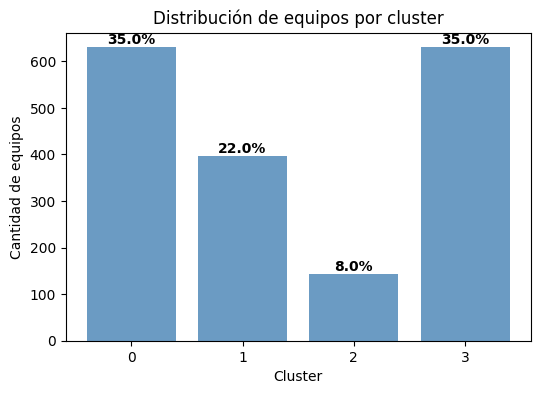

In [ ]:
# 9) Cantidad y porcentaje de equipos por cluster
cluster_counts = df["Cluster"].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(df)) * 100

print("Distribución de equipos por cluster:")
print(pd.DataFrame({"Cantidad": cluster_counts, "%": cluster_percentages.round(2)}))

# 10) Gráfico de barras con cantidades y porcentajes
plt.figure(figsize=(6,4))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color="steelblue", alpha=0.8)

# Etiquetas con % encima de cada barra
for bar, pct in zip(bars, cluster_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{pct:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.ylabel("Cantidad de equipos")
plt.xlabel("Cluster")
plt.title("Distribución de equipos por cluster")
plt.xticks(cluster_counts.index)
plt.show()


In [ ]:
import os
output_path = os.path.join(path_files, "ISR1000_dataset_labeled_clusters&risks.csv")
df.to_csv(output_path, index=False)
print(f"✅ Dataset guardado en: {output_path}")

✅ Dataset guardado en: /content/drive/MyDrive/Colab Notebooks/Files/ISR1000_dataset_labeled_clusters&risks.csv


# **4 - Classification Model**


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1) Mapear clusters a riesgo
risk_map = {2: "Alta", 0: "Media", 1: "Media", 3: "Baja"}
df["Risk_Label"] = df["Cluster"].map(risk_map)

# 2) Features y target
features = ["Operating_Temperature_Nominal",
            "Operating_Humidity_Nominal",
            "Fan_Speed",
            "CPU",
            "Memory"]

X = df[features].values
y = df["Risk_Label"].values

# 3) Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 4) Clasificador
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)




RandomForestClassifier(n_estimators=200, random_state=42)

🎯 Accuracy: 1.00

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        Alta       1.00      1.00      1.00        36
        Baja       1.00      1.00      1.00       157
       Media       1.00      1.00      1.00       257

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



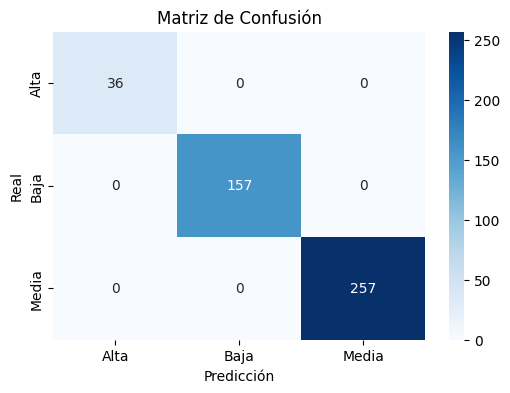

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


# 1) Predicciones
y_pred = clf.predict(X_test)

# 2) Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {accuracy:.2f}")

# 3) Reporte detallado
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 4) Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


# ***Analyze new Devices***


In [ ]:
features = ["Operating_Temperature_Nominal",
            "Operating_Humidity_Nominal",
            "Fan_Speed",
            "CPU",
            "Memory"]
new_data = pd.DataFrame({
    "Operating_Temperature_Nominal": np.random.uniform(30, 60, 20),
    "Operating_Humidity_Nominal": np.random.uniform(40, 70, 20),
    "Fan_Speed": np.random.uniform(7000, 8000, 20),
    "CPU": np.random.uniform(30, 80, 20),
    "Memory": np.random.uniform(30, 80, 20),
})

In [ ]:
new_data

,Operating_Temperature_Nominal,Operating_Humidity_Nominal,Fan_Speed,CPU,Memory
0,36.505027,45.188094,7432.741970,66.875434,62.267562
1,58.655213,49.798239,7245.018323,71.036053,39.543396
2,57.909851,43.261443,7481.786813,51.830851,67.484411
3,38.797114,61.049717,7286.587624,54.446353,35.434821
4,43.935568,62.056703,7142.153595,69.344602,60.599626
5,45.102520,60.930045,7379.314797,44.072527,66.802487
6,50.791503,49.716244,7012.917380,78.525291,47.550980
7,55.115352,54.832579,7193.527288,39.532660,63.893110
8,41.193882,47.395662,7288.831664,69.569745,44.671075
9,43.301615,47.753670,7295.291878,66.086068,73.026009


In [ ]:
# Predicciones de clase
y_new_pred = clf.predict(new_data[features])

# Añadir columna de riesgo al dataset
new_data["Predicted_Risk"] = y_new_pred

print(new_data)


    Operating_Temperature_Nominal  Operating_Humidity_Nominal    Fan_Speed  \
0                       36.505027                   45.188094  7432.741970   
1                       58.655213                   49.798239  7245.018323   
2                       57.909851                   43.261443  7481.786813   
3                       38.797114                   61.049717  7286.587624   
4                       43.935568                   62.056703  7142.153595   
5                       45.102520                   60.930045  7379.314797   
6                       50.791503                   49.716244  7012.917380   
7                       55.115352                   54.832579  7193.527288   
8                       41.193882                   47.395662  7288.831664   
9                       43.301615                   47.753670  7295.291878   
10                      48.733426                   67.048500  7702.414295   
11                      56.362606                   52.050443  7

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


/tmp/ipython-input-3980176541.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_counts.index, y=risk_counts.values, palette="Set2")


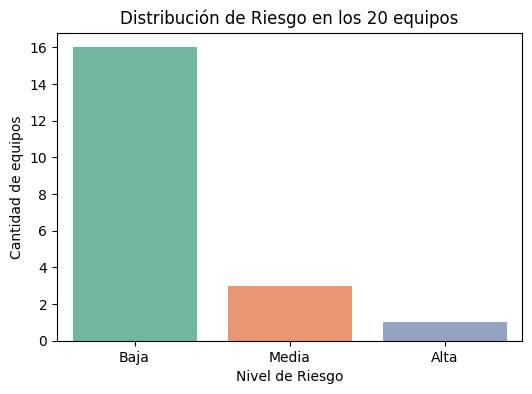

In [ ]:
# Conteo de equipos por clase de riesgo
risk_counts = new_data["Predicted_Risk"].value_counts()

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette="Set2")
plt.title("Distribución de Riesgo en los 20 equipos")
plt.xlabel("Nivel de Riesgo")
plt.ylabel("Cantidad de equipos")
plt.show()